# import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sw
import missingno as msno
from tqdm.notebook import tqdm

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

import lightgbm as lgb
import xgboost as xgb

import optuna
import optuna.visualization as vis

import warnings
warnings.filterwarnings('ignore')

# get data

In [ ]:
!unzip -q '/content/domain-network-security.zip'

In [ ]:
raw_train = pd.read_csv('/content/train.csv')
raw_test = pd.read_csv('/content/test.csv')
raw_sub = pd.read_csv('/content/sample submission.csv')

In [ ]:
print(raw_train.info())
raw_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45870 entries, 0 to 45869
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    45870 non-null  int64  
 1   Source Port           36683 non-null  float64
 2   Destination Port      36693 non-null  float64
 3   NAT Source Port       36756 non-null  float64
 4   NAT Destination Port  36674 non-null  float64
 5   Bytes                 36607 non-null  float64
 6   Bytes Sent            36764 non-null  float64
 7   Bytes Received        36693 non-null  float64
 8   Packets               36818 non-null  float64
 9   Elapsed Time (sec)    36584 non-null  float64
 10  pkts_sent             36667 non-null  float64
 11  pkts_received         36711 non-null  float64
 12  Action                45870 non-null  object 
dtypes: float64(11), int64(1), object(1)
memory usage: 4.5+ MB
None


,ID,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,59276,49418.0,27015.0,54748.0,NaN,78.0,78.0,0.0,1.0,29.0,1.0,0.0,allow
1,18986,58120.0,25174.0,NaN,0.0,66.0,66.0,0.0,NaN,0.0,1.0,0.0,deny
2,11131,46751.0,53.0,46751.0,53.0,220.0,90.0,130.0,2.0,30.0,NaN,1.0,allow
3,57352,52596.0,NaN,0.0,0.0,66.0,66.0,0.0,1.0,NaN,1.0,0.0,drop
4,17229,50584.0,6881.0,29773.0,NaN,502.0,150.0,352.0,2.0,1200.0,NaN,1.0,allow


# eda

In [ ]:
eda_train = raw_train.drop('ID', axis=1)
eda_test = raw_test.drop('ID', axis=1)

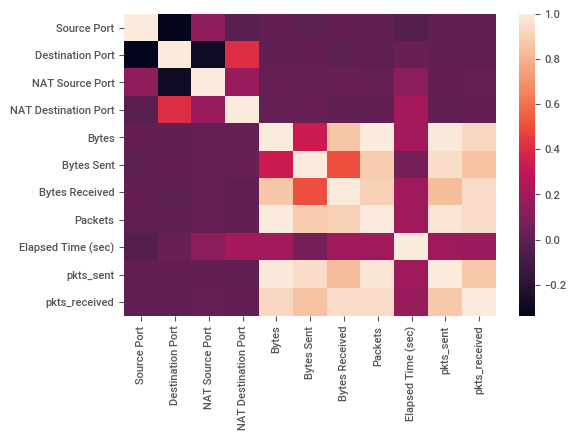

In [ ]:
sns.heatmap(eda_train.corr())

# preprocess

In [ ]:
train = raw_train.drop(['ID', 'Action'], axis=1)
test = raw_test.drop('ID', axis=1)
target = raw_train['Action']

In [ ]:
train = train.fillna(-999).astype(int)
test = test.fillna(-999).astype(int)

In [ ]:
iter_imp = IterativeImputer(missing_values=-999, random_state=1234)
sc = StandardScaler()

In [ ]:
train = pd.DataFrame(iter_imp.fit_transform(train), columns=train.columns)

In [ ]:
test = pd.DataFrame(iter_imp.transform(test), columns=test.columns)

In [ ]:
train = pd.DataFrame(sc.fit_transform(train), columns=train.columns)
test = pd.DataFrame(sc.transform(test), columns=test.columns)

In [ ]:
train.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,0.002215,0.898552,1.734994,0.631900,-0.017979,-0.008805,-0.031833,-0.019590,-0.130657,-0.013566,-0.027153
1,0.611718,0.797543,-0.501182,-0.126882,-0.017981,-0.008812,-0.031833,-0.020474,-0.232511,-0.013566,-0.027153
2,-0.184587,-0.580746,1.344027,-0.124441,-0.017957,-0.008799,-0.031781,-0.019423,-0.127145,-0.013234,-0.026734
3,0.224807,0.150334,-0.941591,-0.126882,-0.017981,-0.008812,-0.031833,-0.019590,-0.174585,-0.013566,-0.027153
4,0.083883,-0.206121,0.513987,0.488106,-0.017914,-0.008768,-0.031691,-0.019423,3.982143,-0.012451,-0.026734


# lightgbm

In [ ]:
# Functions for KFold evaluation
def create(hyperparams):
    """Create LGBM Classifier for a given set of hyper-parameters."""
    model = lgb.LGBMClassifier(**hyperparams)
    return model

def fit(model, X, y):
    """Simple training of a given model."""
    model.fit(X, y)
    return model

def fit_with_stop(model, X, y, X_val, y_val, esr):
    """Advanced training with early stopping."""
    model.fit(
        X, y,
        eval_set=(X_val, y_val),
        early_stopping_rounds=esr, 
        verbose=0,
    )
    return model

def evaluate(model, X, y):
    """Compute AUC for a given model."""
    yp = model.predict(X)
    roc = f1_score(y, yp, average='weighted')
    return roc

def kfold_evaluation(X, y, k, hyperparams, esr=100):
    """Run a KFlod evaluation."""
    scores = []
    
    print(f"\n------ {k}-fold evaluation -----")
    # print(hyperparams)
    
    kf = KFold(k)
    for i, (train_idx, test_idx) in enumerate(kf.split(X)):
        # print(f"\n----- FOLD {i} -----")
        
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[test_idx]
        y_val = y.iloc[test_idx]
        
        model = create(hyperparams)
        model = fit_with_stop(model, X_train, y_train, X_val, y_val, esr)
        train_score = evaluate(model, X_train, y_train)
        val_score = evaluate(model, X_val, y_val)
        scores.append((train_score, val_score))
        
        print(f"Fold {i} | Eval F1 Score: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns=['train score', 'validation score'])
    
    return scores

def kfold_prediction(X, y, X_test, k, hyperparams, esr=100):
    """Make predictions with a bagged model based on KFold."""
    yp = np.zeros(len(X_test))
    
    print(f"\n------ {k}-fold evaluation -----")
    # print(hyperparams)
    
    kf = KFold(k)
    for i, (train_idx, test_idx) in tqdm(enumerate(kf.split(X)), total=k):
        # print(f"\n----- FOLD {i} -----")
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[test_idx]
        y_val = y.iloc[test_idx]
        
        model = create(hyperparams)
        model = fit_with_stop(model, X_train, y_train, X_val, y_val, esr)
        yp += model.predict(X_test) / k
    
    return yp

In [ ]:
# Constant
K = 5
X = train
Y = target
X_TEST = test.copy()
BEST_PARAMS = {
    'objective': 'multiclass',
    'n_estimators': 10000, # Waiting for early-stopping
    'learning_rate': 0.05, # Me
    'metric': 'multi_logloss' # Me
}

In [ ]:
# objective function
def objective(trial):
    # Search spaces
    hyperparams = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 5, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200)
    }
    
    # Add BEST_PARAMS
    hyperparams.update(BEST_PARAMS)
    
    # Evaluation
    scores = kfold_evaluation(X, Y, K, hyperparams, 100)
    
    return scores['validation score'].mean()

In [ ]:
# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2021-04-09 08:43:51,525] A new study created in memory with name: no-name-0d4ed30e-aaa7-4f84-ac43-a7ef0e3b06df



------ 5-fold evaluation -----
Fold 0 | Eval F1 Score: 0.9816733856854196
Fold 1 | Eval F1 Score: 0.9812721977299846
Fold 2 | Eval F1 Score: 0.9837533926439497
Fold 3 | Eval F1 Score: 0.9816444145678435


[I 2021-04-09 08:44:52,918] Trial 0 finished with value: 0.9823591303403024 and parameters: {'reg_alpha': 6.048646497953766, 'reg_lambda': 9.35768025408642, 'num_leaves': 196, 'min_child_samples': 30, 'max_depth': 7, 'colsample_bytree': 0.4209609546247959, 'cat_smooth': 32, 'cat_l2': 9, 'min_data_per_group': 65}. Best is trial 0 with value: 0.9823591303403024.


Fold 4 | Eval F1 Score: 0.9834522610743145

------ 5-fold evaluation -----
Fold 0 | Eval F1 Score: 0.9831101868029475
Fold 1 | Eval F1 Score: 0.9830669869315452
Fold 2 | Eval F1 Score: 0.9829806884564185
Fold 3 | Eval F1 Score: 0.9833933181804272


[I 2021-04-09 08:46:47,064] Trial 1 finished with value: 0.9835347465428406 and parameters: {'reg_alpha': 2.0462452123389974, 'reg_lambda': 4.756191254743841, 'num_leaves': 483, 'min_child_samples': 81, 'max_depth': 5, 'colsample_bytree': 0.23349078539195878, 'cat_smooth': 17, 'cat_l2': 19, 'min_data_per_group': 68}. Best is trial 1 with value: 0.9835347465428406.


Fold 4 | Eval F1 Score: 0.9851225523428644

------ 5-fold evaluation -----
Fold 0 | Eval F1 Score: 0.982763383705655
Fold 1 | Eval F1 Score: 0.9825691456576312
Fold 2 | Eval F1 Score: 0.9829899661370904
Fold 3 | Eval F1 Score: 0.983060017048124


[I 2021-04-09 08:47:49,050] Trial 2 finished with value: 0.9832065524472032 and parameters: {'reg_alpha': 3.8180444810858427, 'reg_lambda': 0.9009722278791009, 'num_leaves': 114, 'min_child_samples': 8, 'max_depth': 6, 'colsample_bytree': 0.45004432722000076, 'cat_smooth': 89, 'cat_l2': 7, 'min_data_per_group': 56}. Best is trial 1 with value: 0.9835347465428406.


Fold 4 | Eval F1 Score: 0.9846502496875156

------ 5-fold evaluation -----
Fold 0 | Eval F1 Score: 0.981238072614484
Fold 1 | Eval F1 Score: 0.9812671980629037
Fold 2 | Eval F1 Score: 0.9832091677853392
Fold 3 | Eval F1 Score: 0.9809903684518086


[I 2021-04-09 08:48:41,093] Trial 3 finished with value: 0.9818789591421471 and parameters: {'reg_alpha': 8.037134471213502, 'reg_lambda': 1.779943023381586, 'num_leaves': 154, 'min_child_samples': 85, 'max_depth': 11, 'colsample_bytree': 0.42594456425269367, 'cat_smooth': 61, 'cat_l2': 12, 'min_data_per_group': 182}. Best is trial 1 with value: 0.9835347465428406.


Fold 4 | Eval F1 Score: 0.9826899887961993

------ 5-fold evaluation -----
Fold 0 | Eval F1 Score: 0.9822176219350283
Fold 1 | Eval F1 Score: 0.9818066204614236
Fold 2 | Eval F1 Score: 0.9829913953578164
Fold 3 | Eval F1 Score: 0.9822985213172132


[I 2021-04-09 08:49:35,215] Trial 4 finished with value: 0.9827047376345508 and parameters: {'reg_alpha': 4.857087759651253, 'reg_lambda': 0.5157464708470766, 'num_leaves': 445, 'min_child_samples': 42, 'max_depth': 6, 'colsample_bytree': 0.4737689424114845, 'cat_smooth': 60, 'cat_l2': 11, 'min_data_per_group': 137}. Best is trial 1 with value: 0.9835347465428406.


Fold 4 | Eval F1 Score: 0.9842095291012727


In [ ]:
# Best parameters
BEST_PARAMS.update(study.best_params)
BEST_PARAMS

{'cat_l2': 17,
 'cat_smooth': 32,
 'colsample_bytree': 0.3065089269040589,
 'learning_rate': 0.05,
 'max_depth': 9,
 'metric': 'multi_logloss',
 'min_child_samples': 27,
 'min_data_per_group': 120,
 'n_estimators': 10000,
 'num_leaves': 269,
 'objective': 'multiclass',
 'reg_alpha': 4.352178213134221,
 'reg_lambda': 8.464889708967005}

In [ ]:
# Update hyperparams for prediction
BEST_PARAMS['learning_rate'] = 0.005

In [ ]:
preds = kfold_prediction(X, Y, X_TEST, 10, BEST_PARAMS, 500)


------ 10-fold evaluation -----


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
preds

array([3., 3., 3., ..., 5., 4., 3.])

In [ ]:
sub = pd.DataFrame({
    'ID': raw_test['ID'],
    'Action': preds
})

sub.to_csv('lgb1.csv', index=False)